In [127]:
# Load the dataset and map pass/fail column based on grades
import pandas as pd

# Load the dataset
grouped_df = pd.read_csv("data/grouped_train.csv")

# Check the first few rows of the dataset to ensure it's loaded correctly
print("First 5 rows of the dataset:")
# print(grouped_df.head())

# Map the pass/fail logic based on grades (we will use this logic in a later step)
def map_pass_fail(grade):
    fail_grades = ['F', 'IF', 'W', 'D-', 'F+', 'D+', 'D#', 'D-', 'U', 'W', 'I', 'FF', 'Z', 'M', 'U*', 'ID', 'IB']
    if grade in fail_grades:
        return 0  # Fail
    else:
        return 1  # Pass

# Apply the mapping to create the 'pass_fail' column
grouped_df['pass_fail'] = grouped_df['CHM2210_Grade'].apply(map_pass_fail)

# Check the first few rows again to verify the new column
print("\nFirst 5 rows after adding 'pass_fail' column:")
grouped_df[['CHM2210_Grade', 'pass_fail']].head()


First 5 rows of the dataset:

First 5 rows after adding 'pass_fail' column:


,CHM2210_Grade,pass_fail
0,A,1
1,A-,1
2,A+,1
3,C-,1
4,C,1


In [180]:
y = grouped_df['pass_fail']


# Define the features (X), keeping HS GPA, Converted_SAT, and other relevant features
# We'll exclude any identifier columns (like Pidm) or target columns (like CHM2210_Grade, CHM2210_Points)
feature_columns = ['HS GPA', 'Converted_SAT']  # Include other relevant columns if necessary

# Extract the feature set
X = grouped_df[feature_columns]

# Check the shape of X and y to confirm they align
print("\nShape of X (features):", X.shape)
print("Shape of y (target):", y.shape)

# Check the first few rows of X and y to ensure they are set up correctly
print("\nFirst 5 rows of X (features):")
print(X.head())

print("\nFirst 5 rows of y (target - pass/fail):")
print(y.head())


Shape of X (features): (9383, 2)
Shape of y (target): (9383,)

First 5 rows of X (features):
   HS GPA  Converted_SAT
0    3.44         1280.0
1    2.50         1180.0
2    2.43         1040.0
3    2.61         1010.0
4    3.10          890.0

First 5 rows of y (target - pass/fail):
0    1
1    1
2    1
3    1
4    1
Name: pass_fail, dtype: int64


In [166]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the training and test sets to ensure the split is correct
print("\nShape of X_train (training features):", X_train.shape)
print("Shape of X_test (test features):", X_test.shape)
print("Shape of y_train (training target):", y_train.shape)
print("Shape of y_test (test target):", y_test.shape)


Shape of X_train (training features): (7506, 2)
Shape of X_test (test features): (1877, 2)
Shape of y_train (training target): (7506,)
Shape of y_test (test target): (1877,)


In [168]:
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

# Train the XGBoost Regression model
model = XGBRegressor(random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model: Root Mean Squared Error (RMSE) and R-squared (R²)
rmse = root_mean_squared_error(y_test, y_pred)  # squared=False gives RMSE
r2 = r2_score(y_test, y_pred)

print("\nModel Performance on Test Set:")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-Squared Score: {r2:.2f}")

# Optionally, you can also check the first few predictions vs. actual values
print("\nFirst 5 predicted values vs actual values:")
for pred, actual in zip(y_pred[:5], y_test[:5]):
    print(f"Predicted: {pred:.2f}, Actual: {actual}")


Model Performance on Test Set:
Root Mean Squared Error (RMSE): 0.23
R-Squared Score: -0.22

First 5 predicted values vs actual values:
Predicted: 0.76, Actual: 1
Predicted: 0.99, Actual: 1
Predicted: 0.96, Actual: 1
Predicted: 0.48, Actual: 1
Predicted: 0.98, Actual: 1


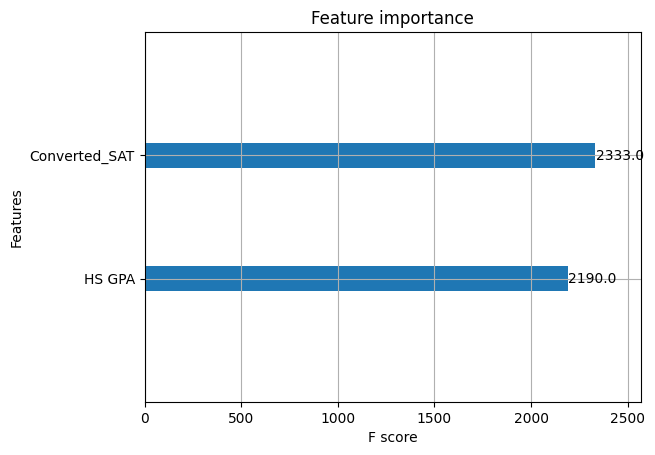

In [170]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot feature importance
xgb.plot_importance(model)
plt.show()

In [171]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model again on scaled data
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_scaled = model.predict(X_test_scaled)

# Evaluate the model again using RMSE and R²
rmse_scaled = root_mean_squared_error(y_test, y_pred_scaled)
r2_scaled = r2_score(y_test, y_pred_scaled)

print("\nModel Performance on Test Set (with Scaled Features):")
print(f"Root Mean Squared Error (RMSE): {rmse_scaled:.2f}")
print(f"R-Squared Score: {r2_scaled:.2f}")

# Check the first few predicted values again
print("\nFirst 5 predicted values vs actual values (with Scaled Features):")
for pred, actual in zip(y_pred_scaled[:5], y_test[:5]):
    print(f"Predicted: {pred:.2f}, Actual: {actual}")



Model Performance on Test Set (with Scaled Features):
Root Mean Squared Error (RMSE): 0.23
R-Squared Score: -0.22

First 5 predicted values vs actual values (with Scaled Features):
Predicted: 0.76, Actual: 1
Predicted: 0.99, Actual: 1
Predicted: 0.96, Actual: 1
Predicted: 0.48, Actual: 1
Predicted: 0.98, Actual: 1


In [175]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define a set of hyperparameters to tune
param_grid = {
    'max_depth': [3, 5, 7],              # Try different tree depths
    'learning_rate': [0.01, 0.1, 0.2],   # Try different learning rates
    'subsample': [0.6, 0.8, 1.0],        # Try different subsample ratios
}

# Create the XGBRegressor model
model = XGBRegressor(random_state=42)

# Use GridSearchCV to search for the best combination of hyperparameters
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')

# Fit the grid search
grid_search.fit(X_train_scaled, y_train)

# Get the best model after tuning
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_best = best_model.predict(X_test_scaled)

# Evaluate the model performance
rmse_best = root_mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print("\nBest Model Performance on Test Set:")
print(f"Root Mean Squared Error (RMSE): {rmse_best:.2f}")
print(f"R-Squared Score: {r2_best:.2f}")

# Display the best hyperparameters
print("\nBest Hyperparameters found:")
print(grid_search.best_params_)



Best Model Performance on Test Set:
Root Mean Squared Error (RMSE): 0.21
R-Squared Score: 0.01

Best Hyperparameters found:
{'learning_rate': 0.01, 'max_depth': 3, 'subsample': 1.0}


In [176]:
from sklearn.metrics import accuracy_score, roc_auc_score

# Round the predicted values to 0 or 1 for pass/fail classification
y_pred_class = [1 if pred >= 0.5 else 0 for pred in y_pred_best]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_class)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_best)

print(f"\nAccuracy: {accuracy:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")



Accuracy: 0.96
ROC-AUC Score: 0.64
